Abhängigkeiten

In [ ]:
%pip install torch
%pip install transformers

Datenvorbereitung

In [1]:
import sqlite3
from sklearn.model_selection import train_test_split

# Connect to the database
conn = sqlite3.connect('data/sentiment.db')
cursor = conn.cursor()

# Fetch the data from the "sentences" table
cursor.execute("SELECT sentence_text, final_sentiment FROM sentences WHERE final_sentiment != 'manual'")
data = cursor.fetchall()

# Close the database connection
conn.close()

# Convert data to a dictionary with the keys "text" and "label"
data = [{"text": text, "label": label} for text, label in data]
# Convert bullish to 0, neutral to 1, and bearish to 2
data = [{"text": row["text"], "label": 0 if row["label"] == "bullish" else 1 if row["label"] == "neutral" else 2} for row in data]

# Split the data into train, test, and validation sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

# Print the sizes of the train, test, and validation sets
print("Train data percentage:", (round((len(train_data) / len(data)) * 100)))
print("Test data percentage:", (round((len(test_data) / len(data)) * 100)))
print("Validation data percentage:", (round((len(val_data) / len(data)) * 100)))

Train data percentage: 72
Test data percentage: 15
Validation data percentage: 13


Tokenization

In [2]:
from transformers import AutoTokenizer
import torch

# Lade den Tokenizer
model_name = 'ahmedrachid/FinancialBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Funktion, um die Daten zu tokenisieren
def tokenize_data(data):
    tokenized_data = []
    for item in data:
        # Tokenisiere den Text und füge das Ergebnis dem Array hinzu
        encoding = tokenizer(
            item['text'],
            padding='max_length',  # Pad kürzere Sätze
            truncation=True,       # Schneide längere Sätze ab
            max_length=512,        # Maximale Länge auf BERT's limit setzen
            return_tensors='pt'    # Rückgabe als PyTorch Tensoren
        )
        tokenized_data.append({'input_ids': encoding['input_ids'].squeeze(0), 'attention_mask': encoding['attention_mask'].squeeze(0), 'label': item['label']})
    return tokenized_data

# Tokenisiere Trainings-, Test- und Validierungsdaten
train_data_tokenized = tokenize_data(train_data)
val_data_tokenized = tokenize_data(val_data)
test_data_tokenized = tokenize_data(test_data)

PyTorch Dataset

In [3]:
from torch.utils.data import Dataset

# Erstelle eine benutzerdefinierte Dataset-Klasse
class SentimentDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        return self.tokenized_data[idx]

# Erstelle PyTorch Datasets
train_dataset = SentimentDataset(train_data_tokenized)
val_dataset = SentimentDataset(val_data_tokenized)
test_dataset = SentimentDataset(test_data_tokenized)

DataLoader

In [4]:
from torch.utils.data import DataLoader

# Definiere Batch-Größe
batch_size = 16

# Erstelle DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training

In [5]:
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch.optim as optim
import json
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import datetime

metrics = {
    'batch': [],
    'train_loss': [],
    'val_loss': [],
    'f1': [],
    'lr': []
}

# Funktion zum Aktualisieren der Metriken nach jeder Epoche
def update_metrics(batch, train_loss, val_loss, f1, lr):
    metrics['batch'].append(batch)
    metrics['train_loss'].append(train_loss)
    metrics['val_loss'].append(val_loss)
    metrics['f1'].append(f1)
    metrics['lr'].append(lr)

# Füge diese Funktion hinzu, um die Validierungsleistung zu bewerten
def evaluate(model, val_loader, device):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    total_eval_loss = 0

    # Listen für wahre Labels und Vorhersagen
    true_labels = []
    predictions = []

    for batch in val_loader:
        # Übertrage die Batch-Daten auf das richtige Device (z.B. GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():  # Deaktiviere die Gradientenberechnung für die Evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        # Berechne Vorhersagen
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        # Sammle wahre Labels und Vorhersagen für Metrikberechnung
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')

    model.train()  # Setze das Modell wieder in den Trainingsmodus
    return total_eval_loss / len(val_loader), f1  # Gib Durchschnittsverlust und Metriken zurück

id2label = {0: 'bullish', 1: 'neutral', 2: 'bearish'}
label2id = {'bullish': 0, 'neutral': 1, 'bearish': 2}

# Modell laden
model = BertForSequenceClassification.from_pretrained('ahmedrachid/FinancialBERT', num_labels=3, id2label=id2label, label2id=label2id)  # Angenommene 3 Labels: bullish, neutral, bearish
model.train()  # Setze das Modell in den Trainingsmodus

# Überprüfen, ob CUDA verfügbar ist und eine GPU zuweisen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Modell auf die GPU verschieben

num_epochs = 3
learning_rate = 5e-5
weight_decay = 0.01 #0.0001
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Timestamp to avoid overwriting

# Optimierer definieren
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Gesamte Trainingssteps und Warm-Up Steps definieren
total_steps = len(train_loader) * num_epochs  # Gesamte Anzahl von Trainingsschritten
warmup_steps = int(total_steps * 0.1)  # 10% der Trainingsschritte als Warm-Up

# Scheduler initialisieren
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


logging_interval = 100 # Logge die Metriken alle 100 Batches

# Create a directory name with hyperparameters
dir_name = f"model_epoch{num_epochs}_lr{learning_rate}_bs{batch_size}_wd001_scheduler_{current_time}"

# Specify the base path where you want to save the models
base_path = "models/"

# Full path
save_path = base_path + dir_name

global_batch = 0

for epoch in range(num_epochs):  # num_epochs ist die Anzahl der Epochen, die du trainieren möchtest
    # Progress bar with tqdm
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", total=len(train_loader), unit="batch")
    
    for batch in train_loader:
        # Extrahiere Daten aus dem Batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)  # Stelle sicher, dass deine Labels als Tensor von numerischen Labels vorliegen

        # Null the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        # optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())
        progress_bar.update()

        global_batch += 1

        if global_batch % logging_interval == 0 and global_batch != 0:
            # Evaluate the model on the validation set
            val_loss, f1 = evaluate(model, val_loader, device)
            update_metrics(global_batch, loss.item(), val_loss, f1, scheduler.get_last_lr()[0]) # scheduler.get_last_lr()[0]
            print(f"Batch: {global_batch}, Learning Rate {scheduler.get_last_lr()[0]}, Validation loss: {val_loss:.3f}, Train loss: {loss.item():.3f}, F1: {f1:.3f}")

    # Save the model after each epoch
    epoch_save_path = f"{save_path}/epoch_{epoch+1}"
    model.save_pretrained(epoch_save_path)

with open(f'{save_path}/metrics.json', 'w') as f:
    json.dump(metrics, f)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ahmedrachid/FinancialBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 3393, Warmup steps: 339


Epoch 1/3:   0%|          | 0/1131 [00:00<?, ?batch/s]

Batch: 100, Learning Rate 5.899705014749263e-06, Validation loss: 0.946, Train loss: 1.056, F1: 0.489
Batch: 200, Learning Rate 1.1799410029498525e-05, Validation loss: 0.370, Train loss: 0.178, F1: 0.867
Batch: 300, Learning Rate 1.769911504424779e-05, Validation loss: 0.307, Train loss: 0.397, F1: 0.878
Batch: 400, Learning Rate 1.9980318923633554e-05, Validation loss: 0.345, Train loss: 0.230, F1: 0.867
Batch: 500, Learning Rate 1.9863167105845718e-05, Validation loss: 0.354, Train loss: 0.074, F1: 0.867
Batch: 600, Learning Rate 1.964173671795681e-05, Validation loss: 0.257, Train loss: 0.152, F1: 0.901
Batch: 700, Learning Rate 1.931836883803822e-05, Validation loss: 0.272, Train loss: 0.313, F1: 0.893
Batch: 800, Learning Rate 1.889648228073363e-05, Validation loss: 0.246, Train loss: 0.382, F1: 0.901
Batch: 900, Learning Rate 1.8380537451759424e-05, Validation loss: 0.249, Train loss: 0.177, F1: 0.905
Batch: 1000, Learning Rate 1.7775989190158592e-05, Validation loss: 0.276, Tra

Epoch 2/3:   0%|          | 0/1131 [00:00<?, ?batch/s]

Batch: 1200, Learning Rate 1.6327517959446903e-05, Validation loss: 0.235, Train loss: 0.120, F1: 0.916
Batch: 1300, Learning Rate 1.5498908987062476e-05, Validation loss: 0.225, Train loss: 0.026, F1: 0.913
Batch: 1400, Learning Rate 1.4612162667907663e-05, Validation loss: 0.296, Train loss: 0.202, F1: 0.900
Batch: 1500, Learning Rate 1.3676654148647985e-05, Validation loss: 0.244, Train loss: 0.009, F1: 0.911
Batch: 1600, Learning Rate 1.2702274115475708e-05, Validation loss: 0.231, Train loss: 0.054, F1: 0.916
Batch: 1700, Learning Rate 1.1699324224593533e-05, Validation loss: 0.240, Train loss: 0.209, F1: 0.911
Batch: 1800, Learning Rate 1.067840818770804e-05, Validation loss: 0.263, Train loss: 0.067, F1: 0.912
Batch: 1900, Learning Rate 9.650319664034088e-06, Validation loss: 0.253, Train loss: 0.087, F1: 0.914
Batch: 2000, Learning Rate 8.625928144074629e-06, Validation loss: 0.240, Train loss: 0.067, F1: 0.915
Batch: 2100, Learning Rate 7.616064031672439e-06, Validation loss: 

Epoch 3/3:   0%|          | 0/1131 [00:00<?, ?batch/s]

Batch: 2300, Learning Rate 5.68235880723657e-06, Validation loss: 0.217, Train loss: 0.010, F1: 0.929
Batch: 2400, Learning Rate 4.778961839932197e-06, Validation loss: 0.225, Train loss: 0.020, F1: 0.930
Batch: 2500, Learning Rate 3.930764423434612e-06, Validation loss: 0.243, Train loss: 0.002, F1: 0.919
Batch: 2600, Learning Rate 3.146734145214112e-06, Validation loss: 0.241, Train loss: 0.304, F1: 0.924
Batch: 2700, Learning Rate 2.435160184137021e-06, Validation loss: 0.272, Train loss: 0.004, F1: 0.916
Batch: 2800, Learning Rate 1.8035656729238914e-06, Validation loss: 0.241, Train loss: 0.007, F1: 0.928
Batch: 2900, Learning Rate 1.258628159648908e-06, Validation loss: 0.254, Train loss: 0.002, F1: 0.927
Batch: 3000, Learning Rate 8.061090092031765e-07, Validation loss: 0.257, Train loss: 0.006, F1: 0.924
Batch: 3100, Learning Rate 4.5079249112663816e-07, Validation loss: 0.249, Train loss: 0.008, F1: 0.924
Batch: 3200, Learning Rate 1.9643519780393805e-07, Validation loss: 0.25

In [11]:
import evaluate

# Lade die Metriken
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()  # Setze das Modell in den Evaluierungsmodus

for batch in test_loader:  # oder test_loader
    inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'].to(device), batch['label']
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)  # Stelle sicher, dass sie auf dem richtigen Gerät sind

    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)

    # Konvertiere die Ausgaben des Modells in Vorhersagen
    logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
    predictions = torch.argmax(logits, dim=-1)

    # Aktualisiere die Metriken mit den Vorhersagen und den wahren Labels
    accuracy_metric.add_batch(predictions=predictions, references=labels)
    f1_metric.add_batch(predictions=predictions, references=labels)

# Berechne die finale Metrik
final_accuracy = accuracy_metric.compute()
final_f1 = f1_metric.compute(average="weighted")  # oder andere Durchschnittswerte je nach Bedarf

print("Accuracy:", final_accuracy)
print("F1-Score:", final_f1)

Accuracy: {'accuracy': 0.9134487350199734}
F1-Score: {'f1': 0.9139093038909855}


Graphen Matplotlib

In [ ]:
%pip install matplotlib

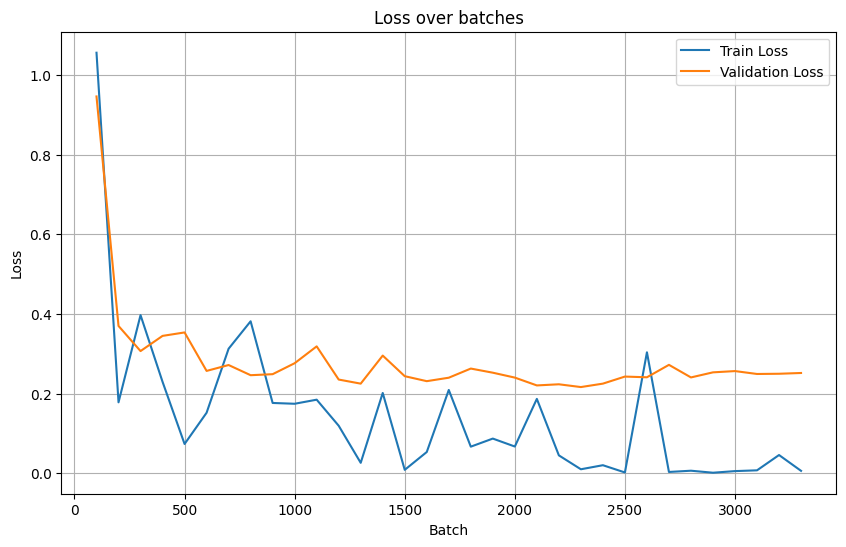

In [6]:
import json
import matplotlib.pyplot as plt

# Lade die Metriken
with open('models/model_epoch3_lr2e-05_bs16_wd00001_scheduler_20240108-011807/metrics.json', 'r') as f:
    metrics = json.load(f)

batches = metrics['batch']
train_losses = metrics['train_loss']
val_losses = metrics['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(batches, train_losses, label='Train Loss')
plt.plot(batches, val_losses, label='Validation Loss')
plt.title('Loss over batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

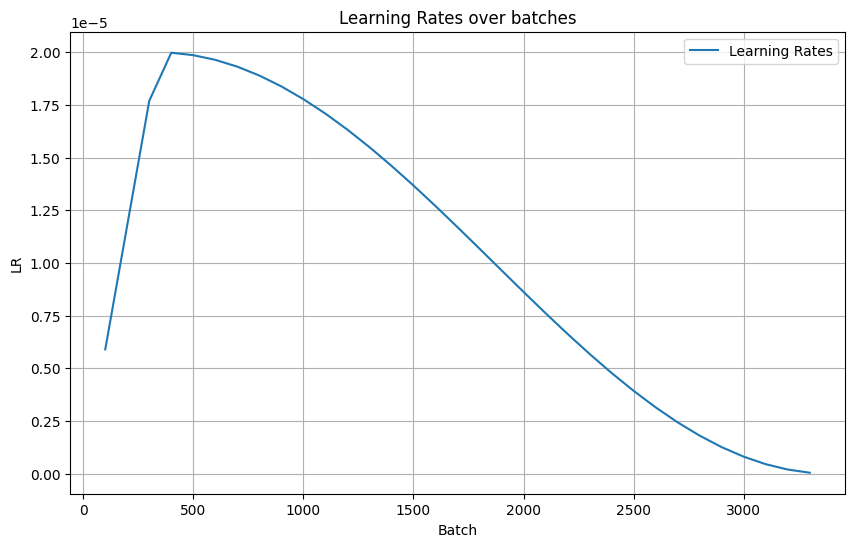

In [10]:
batches = metrics['batch']
lr = metrics['lr']

plt.figure(figsize=(10, 6))
plt.plot(batches, lr, label='Learning Rates')
plt.title('Learning Rates over batches')
plt.xlabel('Batch')
plt.ylabel('LR')
plt.grid(True)
plt.legend()
plt.show()

Konfusionsmatrix

In [ ]:
%pip install seaborn

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels_list = []
predictions_list = []

# Angenommen, dies ist deine Validierungsschleife oder ein separater Evaluierungsprozess
for batch in val_loader:  # oder test_loader
    inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)  # Stelle sicher, dass sie auf dem richtigen Gerät sind

    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        # Hier bekommen wir die Logits (die Rohausgabe des Modells vor der Anwendung der Aktivierungsfunktion).
        logits = outputs.logits  # oder outputs[0], abhängig von deinem Modell

        # Bestimme die Klasse mit der höchsten Score für jede Eingabe in der Batch
        _, predictions = torch.max(logits, dim=1)

    # Sammle die wahren Labels und die Vorhersagen
    true_labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())

# Nachdem du alle Vorhersagen gesammelt hast, konvertiere Listen in Arrays
true_labels = np.array(true_labels_list)
predictions = np.array(predictions_list)


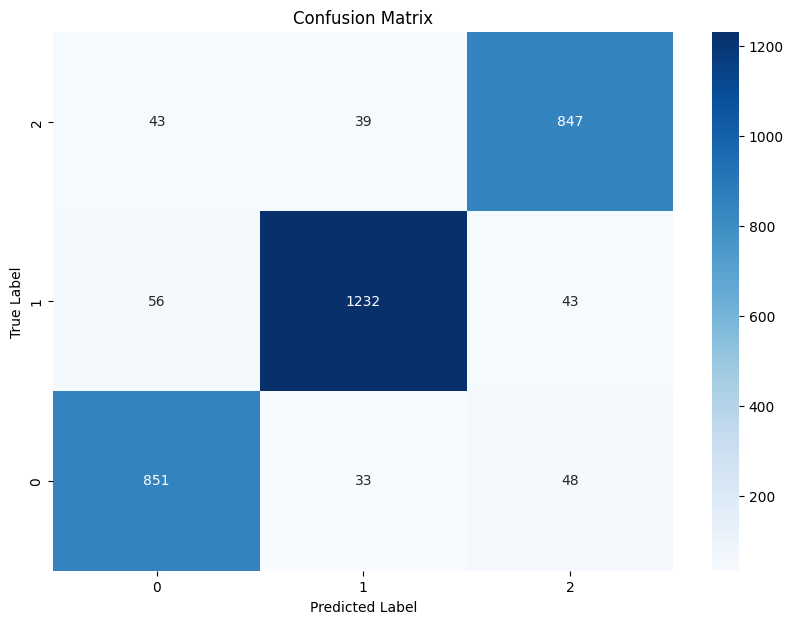

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Berechne die Konfusionsmatrix
cm = confusion_matrix(true_labels, predictions)

# Umdrehen der Matrix, so dass die Klasse 0 unten links ist
cm_flipped = np.flipud(cm)

# Visualisiere die umgedrehte Konfusionsmatrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_flipped, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Korrigiere die y-Achsen-Beschriftungen
# plt.yticks() nimmt zwei Argumente: Die Positionen und die Labels der Ticks
# Wir stellen die Positionen so ein, dass sie auf die Mitte der Kästen zeigen
plt.yticks(np.arange(0.5, len(cm)), labels=np.arange(len(cm))[::-1])

plt.show()